In [196]:
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True


In [197]:
RUNS_DIR = Path("../runs")

metric_files = sorted(RUNS_DIR.glob("*/metrics.json"))
print(f"Found {len(metric_files)} runs")

runs = []
for p in metric_files:
    with open(p) as f:
        runs.append(json.load(f))

assert len(runs) > 0, "No runs found"


Found 10 runs


In [198]:
def stack_metric(runs, key):
    return np.stack(
        [np.array(r[key], dtype=float) for r in runs],
        axis=0
    )


In [199]:
k = np.array(runs[0]["k"])

metrics = {
    "Overlap": stack_metric(runs, "mean_overlap"),
    "Distance Divergence": stack_metric(runs, "mean_dist_divergence"),
    "Barycenter Shift": stack_metric(runs, "mean_barycenter_shift"),
    "LID Difference": stack_metric(runs, "mean_lid_diff"),
    "LID Exact": stack_metric(runs, "lid_exact"),
    "LID ANN": stack_metric(runs, "lid_ann"),
}


In [200]:
def summarize_ci(curves, z=1.96):
    mean = np.nanmean(curves, axis=0)
    std  = np.nanstd(curves, axis=0)
    n    = np.sum(np.isfinite(curves), axis=0)
    se   = std / np.sqrt(n)
    return mean, mean - z*se, mean + z*se


In [201]:
def plot_curve(k, mean, lo=None, hi=None, title="", ylabel=""):
    plt.figure()
    plt.plot(k, mean, lw=2)
    if lo is not None:
        plt.fill_between(k, lo, hi, alpha=0.25)
    plt.xlabel("k")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


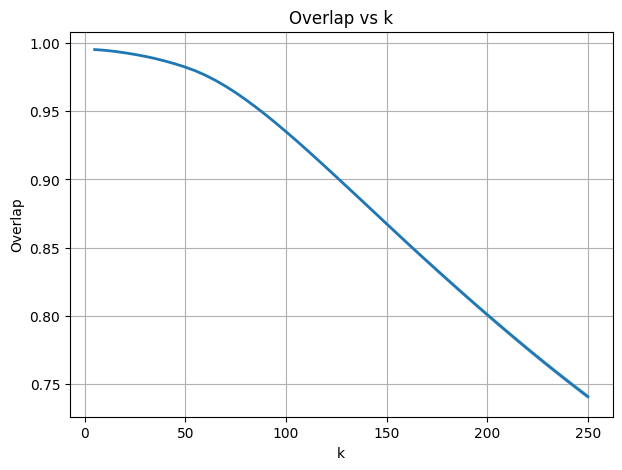

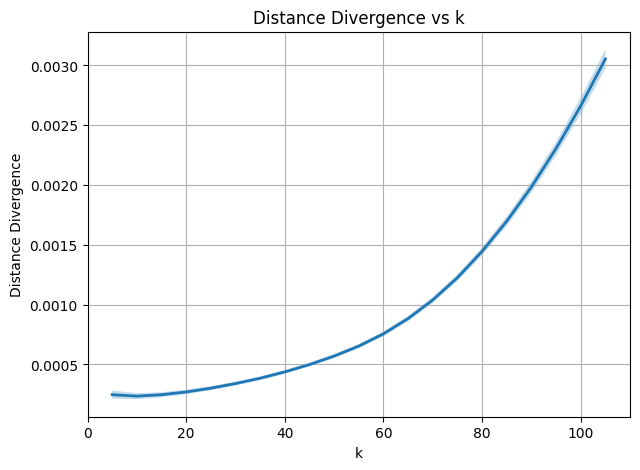

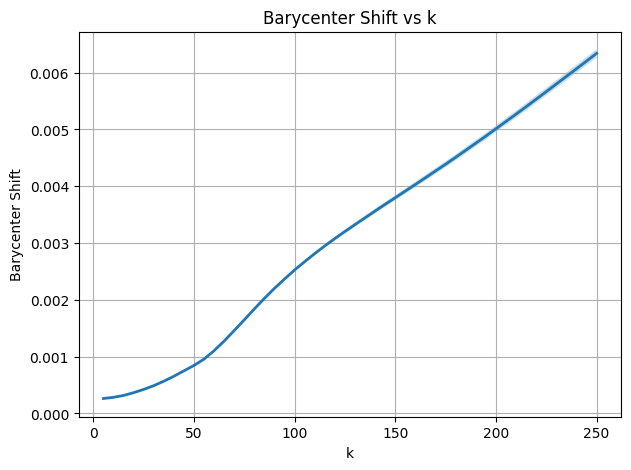

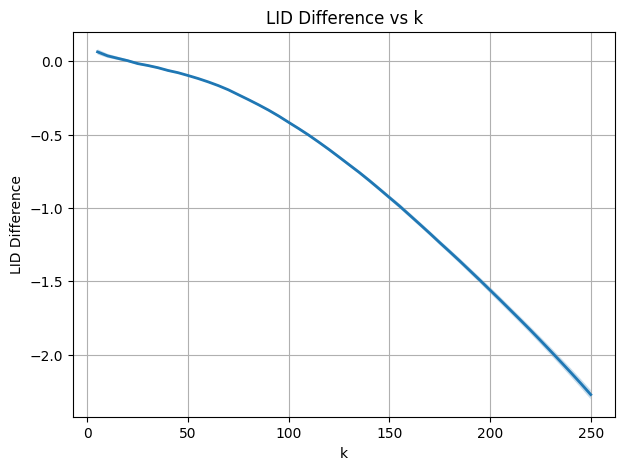

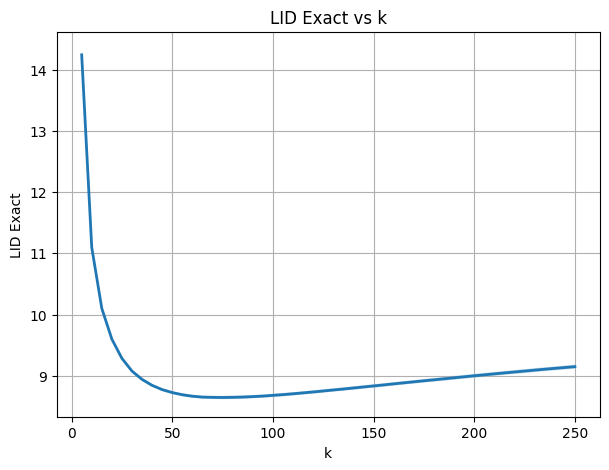

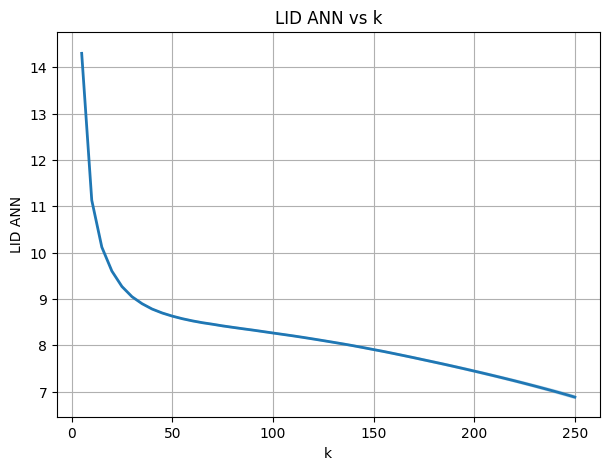

In [202]:
for name, curves in metrics.items():
    mean, lo, hi = summarize_ci(curves)
    plot_curve(
        k,
        mean,
        lo,
        hi,
        title=f"{name} vs k",
        ylabel=name
    )


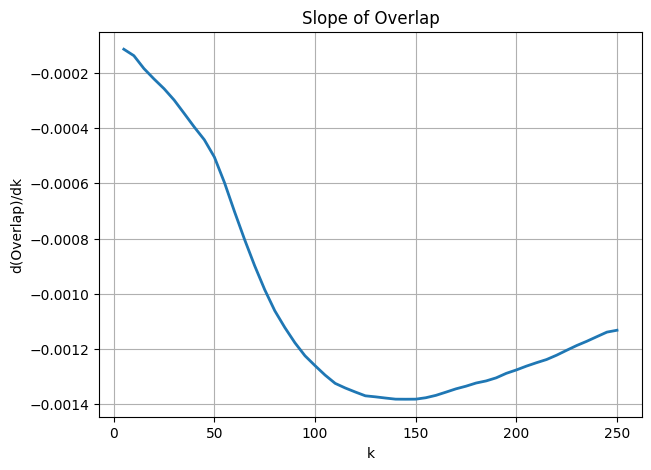

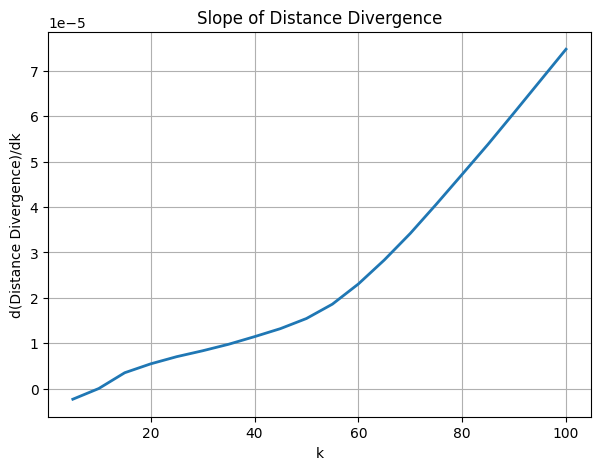

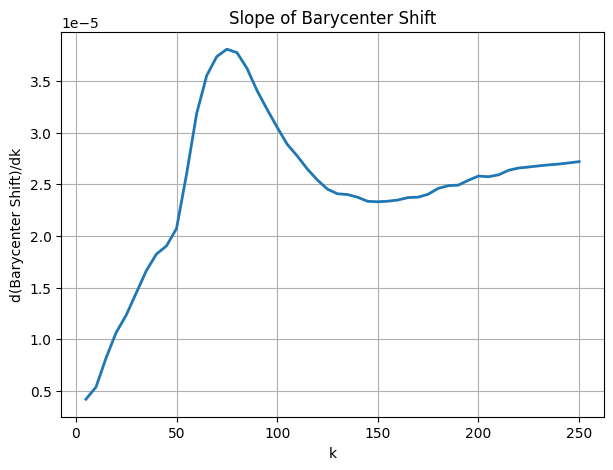

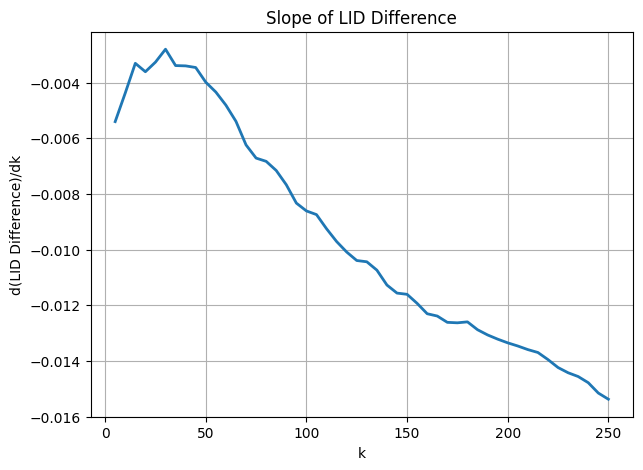

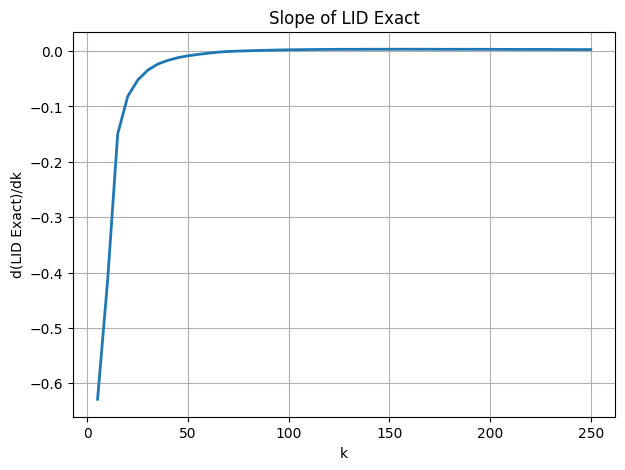

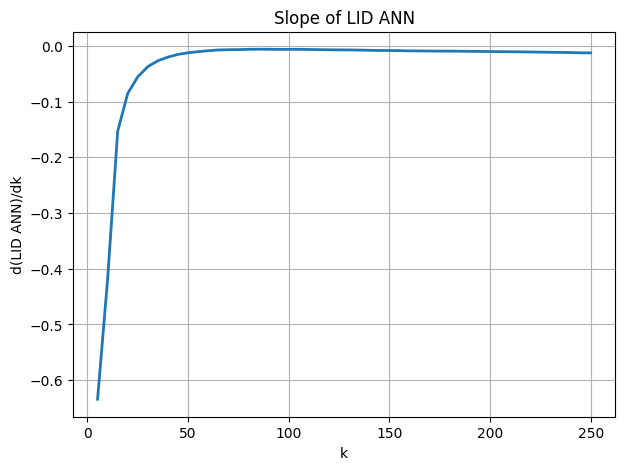

In [203]:
def first_derivative(y, x):
    return np.gradient(y, x)

for name, curves in metrics.items():
    mean, _, _ = summarize_ci(curves)
    slope = first_derivative(mean, k)

    plt.figure()
    plt.plot(k, slope, lw=2)
    plt.xlabel("k")
    plt.ylabel(f"d({name})/dk")
    plt.title(f"Slope of {name}")
    plt.show()


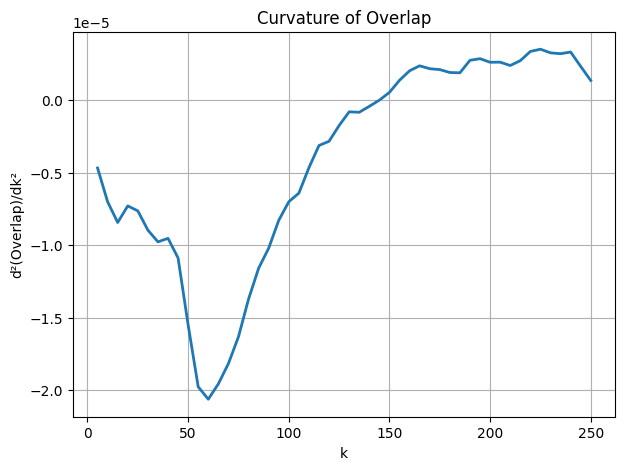

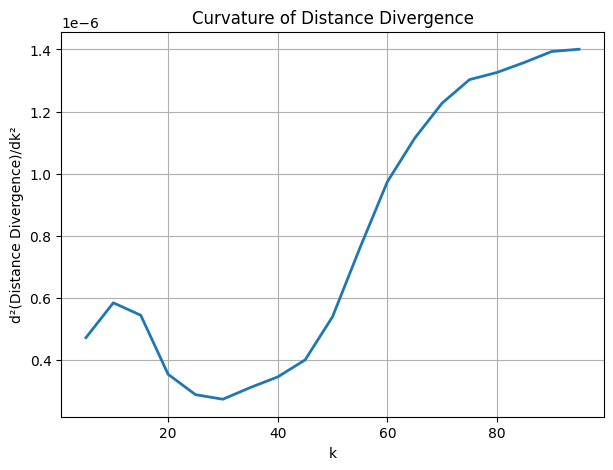

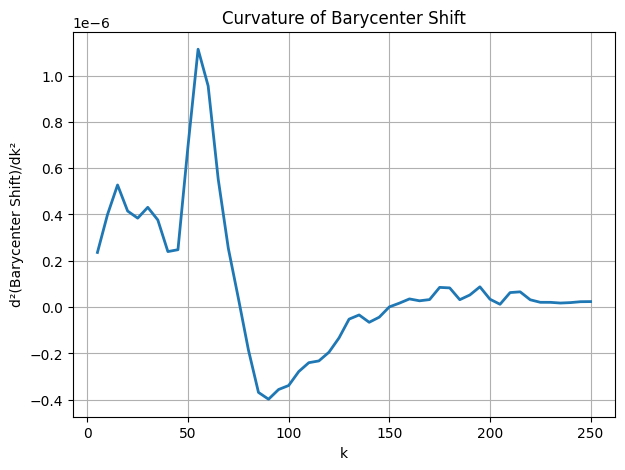

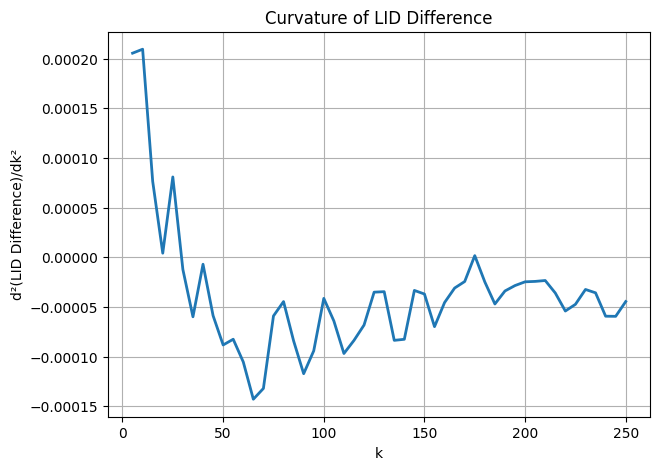

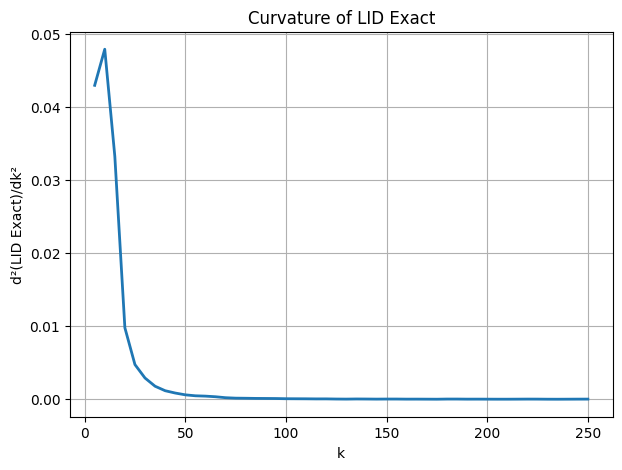

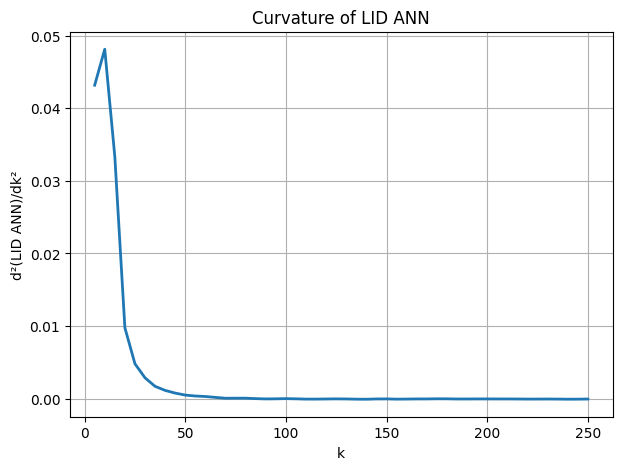

In [204]:
def second_derivative(y, x):
    return np.gradient(np.gradient(y, x), x)

for name, curves in metrics.items():
    mean, _, _ = summarize_ci(curves)
    curvature = second_derivative(mean, k)

    plt.figure()
    plt.plot(k, curvature, lw=2)
    plt.xlabel("k")
    plt.ylabel(f"d²({name})/dk²")
    plt.title(f"Curvature of {name}")
    plt.show()


In [205]:
import json
import numpy as np
from pathlib import Path

RUNS_DIR = Path("../runs")   # adjust if needed

all_runs = []

for run_dir in sorted(RUNS_DIR.iterdir()):
    metrics_path = run_dir / "metrics.json"
    if metrics_path.exists():
        with open(metrics_path, "r") as f:
            all_runs.append(json.load(f))

print(f"Loaded {len(all_runs)} runs")


Loaded 10 runs


In [206]:
k = np.array(all_runs[0]["k"])


In [207]:
def stack_metric(name):
    return np.array([run[name] for run in all_runs], dtype=float)


In [208]:
mean_overlap = stack_metric("mean_overlap").mean(axis=0)
std_overlap  = stack_metric("std_overlap").mean(axis=0)

mean_dist_div = stack_metric("mean_dist_divergence").mean(axis=0)
std_dist_div  = stack_metric("std_dist_divergence").mean(axis=0)

mean_bary_shift = stack_metric("mean_barycenter_shift").mean(axis=0)
std_bary_shift  = stack_metric("std_barycenter_shift").mean(axis=0)

lid_exact = stack_metric("lid_exact").mean(axis=0)
lid_ann   = stack_metric("lid_ann").mean(axis=0)

lid_diff  = stack_metric("mean_lid_diff").mean(axis=0)
std_lid_diff = stack_metric("std_lid_diff").mean(axis=0)


In [209]:
import matplotlib.pyplot as plt
import numpy as np

def plot_exact_vs_ann(
    k,
    exact,
    ann,
    ylabel,
    title,
    logy=False,
):
    plt.figure(figsize=(6, 4))
    
    plt.plot(k, exact, label="Exact", linewidth=2)
    plt.plot(k, ann, label="ANN", linewidth=2, linestyle="--")

    if logy:
        plt.yscale("log")

    plt.xlabel("k")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


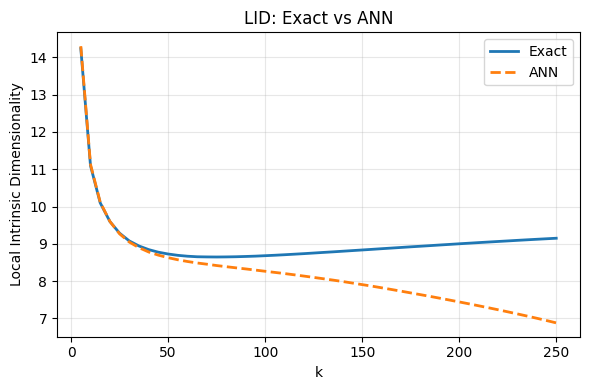

In [210]:
plot_exact_vs_ann(
    k,
    lid_exact,
    lid_ann,
    ylabel="Local Intrinsic Dimensionality",
    title="LID: Exact vs ANN",
)


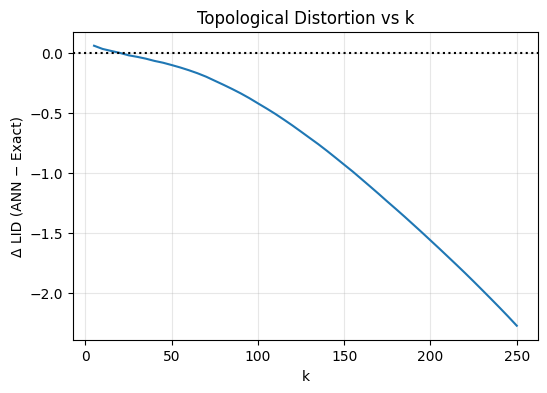

In [211]:
plt.figure(figsize=(6,4))
plt.plot(k, lid_diff)
plt.axhline(0, linestyle=":", color="black")
plt.xlabel("k")
plt.ylabel("Δ LID (ANN − Exact)")
plt.title("Topological Distortion vs k")
plt.grid(alpha=0.3)
plt.show()


In [212]:
def plot_exact_vs_ann(k, exact, ann, ylabel, title):
    plt.figure(figsize=(6,4))
    plt.plot(k, exact, label="Exact", linewidth=2)
    plt.plot(k, ann, label="ANN", linestyle="--", linewidth=2)
    plt.xlabel("k")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


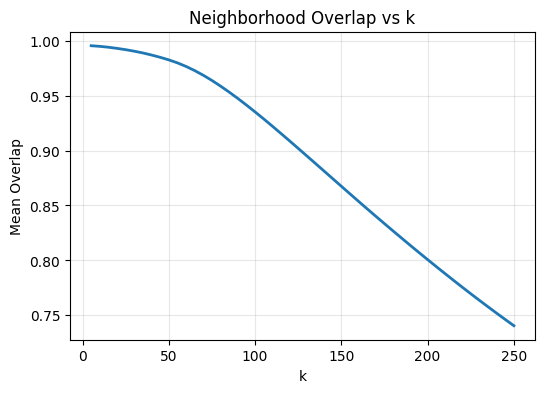

In [213]:
plt.figure(figsize=(6,4))
plt.plot(k, mean_overlap, linewidth=2)
plt.xlabel("k")
plt.ylabel("Mean Overlap")
plt.title("Neighborhood Overlap vs k")
plt.grid(alpha=0.3)
plt.show()


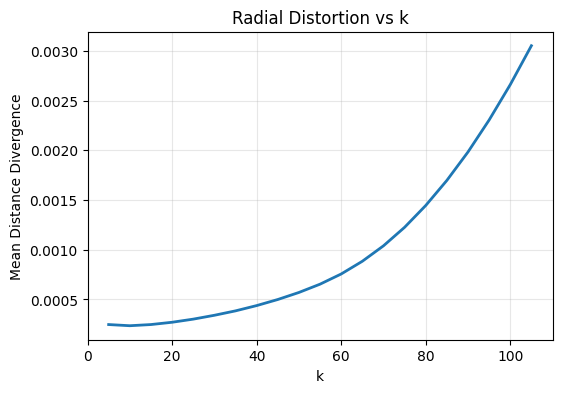

In [214]:
finite = np.isfinite(mean_dist_div)

plt.figure(figsize=(6,4))
plt.plot(k[finite], mean_dist_div[finite], linewidth=2)
plt.xlabel("k")
plt.ylabel("Mean Distance Divergence")
plt.title("Radial Distortion vs k")
plt.grid(alpha=0.3)
plt.show()


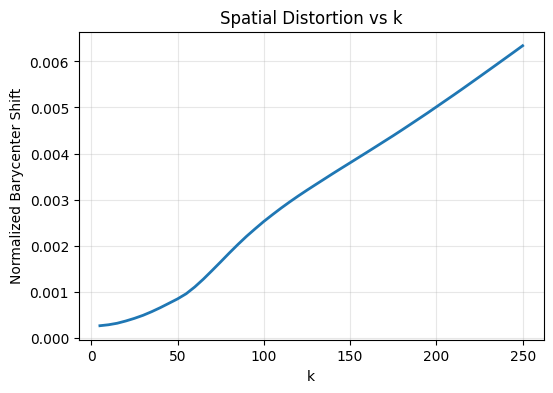

In [215]:
plt.figure(figsize=(6,4))
plt.plot(k, mean_bary_shift, linewidth=2)
plt.xlabel("k")
plt.ylabel("Normalized Barycenter Shift")
plt.title("Spatial Distortion vs k")
plt.grid(alpha=0.3)
plt.show()


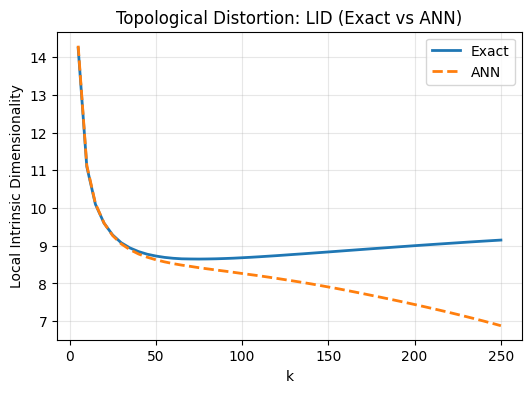

In [216]:
plot_exact_vs_ann(
    k,
    lid_exact,
    lid_ann,
    ylabel="Local Intrinsic Dimensionality",
    title="Topological Distortion: LID (Exact vs ANN)"
)


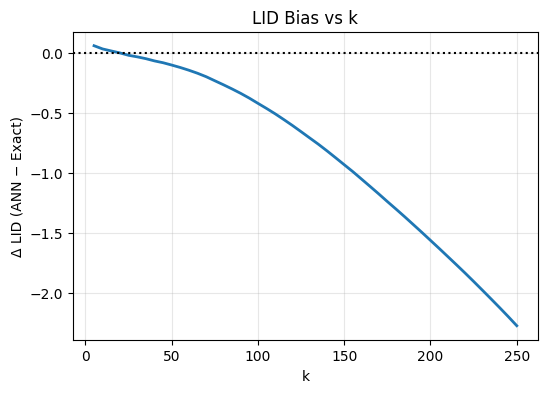

In [217]:
plt.figure(figsize=(6,4))
plt.plot(k, lid_diff, linewidth=2)
plt.axhline(0, linestyle=":", color="black")
plt.xlabel("k")
plt.ylabel("Δ LID (ANN − Exact)")
plt.title("LID Bias vs k")
plt.grid(alpha=0.3)
plt.show()


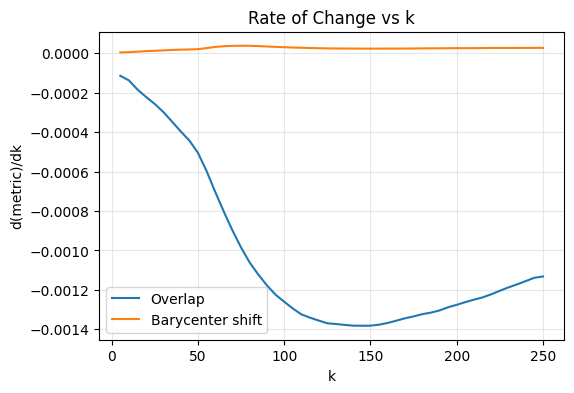

In [218]:
def first_derivative(y, x):
    return np.gradient(y, x)

plt.figure(figsize=(6,4))
plt.plot(k, first_derivative(mean_overlap, k), label="Overlap")
plt.plot(k, first_derivative(mean_bary_shift, k), label="Barycenter shift")
plt.xlabel("k")
plt.ylabel("d(metric)/dk")
plt.title("Rate of Change vs k")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
